In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.parallel import parallel_func as Parallel

import pandas as pd
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm_notebook
import math
import numpy as np
import pandas as pd

from itertools import product
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

#Import Monthly Index Data

In [ ]:
df = pd.read_csv('Hang Seng Index_Monthly.csv')
df = df[['Date','Close']]
df

,Date,Close
0,2017-01-01,23360.779297
1,2017-02-01,23740.730469
2,2017-03-01,24111.589844
3,2017-04-01,24615.130859
4,2017-05-01,25660.650391
...,...,...
64,2022-05-01,21415.199219
65,2022-06-01,21859.789063
66,2022-07-01,20156.509766
67,2022-08-01,19954.390625


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    69 non-null     object 
 1   Close   69 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In [ ]:
# Convert Date to datetime
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df

,Close
Date,
2017-01-01,23360.779297
2017-02-01,23740.730469
2017-03-01,24111.589844
2017-04-01,24615.130859
2017-05-01,25660.650391
...,...
2022-05-01,21415.199219
2022-06-01,21859.789063
2022-07-01,20156.509766


In [ ]:
fig = px.line(df, y= 'Close', title='Stock Close Price Changes', template = 'plotly_dark')
fig.show()

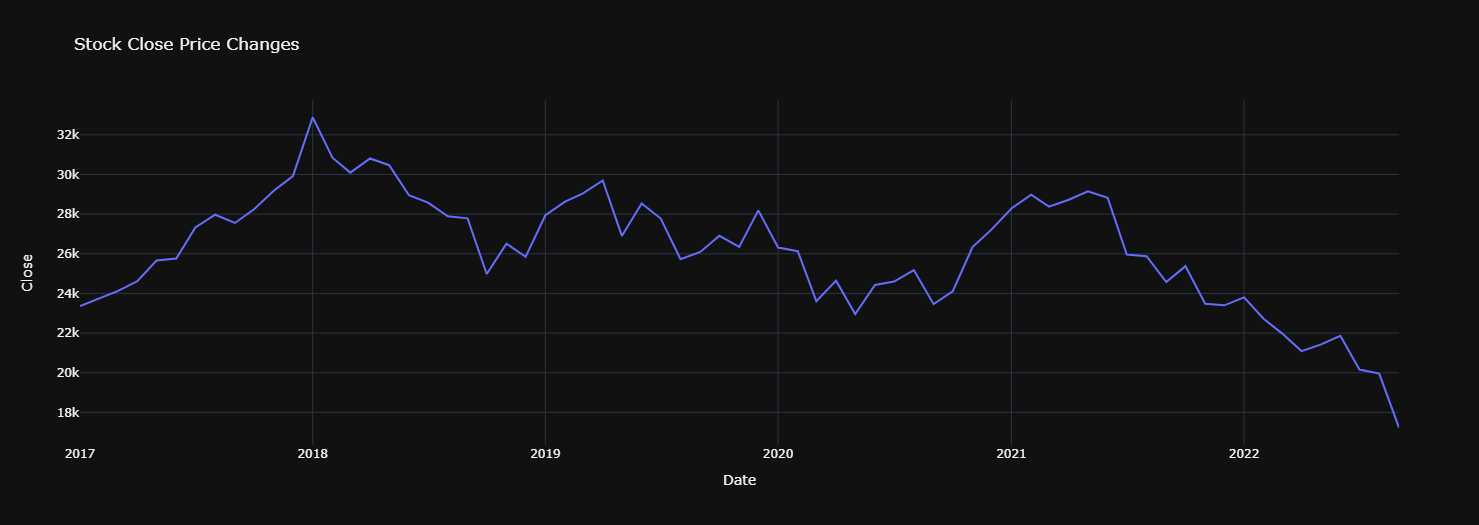

# Augmented Dickey-Fuller test to check for dataset stationarity
- Augmented Dickey-Fuller unit root test.

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.



In [ ]:
passing_data=adfuller(df['Close'])
passing_data

(-0.2577016009143149,
 0.9312850791504195,
 1,
 67,
 {'1%': -3.5319549603840894,
  '5%': -2.905755128523123,
  '10%': -2.5903569458676765},
 987.4529587262712)

In [ ]:
type(df['Close'])

pandas.core.series.Series

In [ ]:
def adf_test(series):
  result=adfuller(series)
  labels = ['Test parameters', 'p-value','#Lags Used','Num of Observations Used'] 
  for value,label in zip(result,labels):
      print(label+' : '+str(value) )
  if result[1] <= 0.05:
      print("Dataset is stationary")
  else:
      print("Dataset is non-stationary ")  

adf_test(df['Close'])

Test parameters : -0.2577016009143149
p-value : 0.9312850791504195
#Lags Used : 1
Num of Observations Used : 67
Dataset is non-stationary 


- p-value: 0.9312850791504195
- This number is greater than 0.05. It implies that the time series is non-stationary.

# Transformation to Stationary Time Series Using Differencing
The observations in a stationary time series are not dependent on time.

Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

In [ ]:
def differencing(data, column, order):
    #difference that series at lag-12 because our data were collected monthly.
    data['Close_diff'] = data[column].diff(order)
    data['Close_diff'].fillna(data['Close_diff'].mean(), inplace=True)
    #data['Close_diff']=df['Close']-df['Close'].shift(12)
    #data['Close_diff'].fillna(data['Close_diff'].mean(), inplace=True)
    return data
differenced_df = differencing(df, 'Close',1)
differenced_df 

,Close,Close_diff
Date,,
2017-01-01,23360.779297,-90.263959
2017-02-01,23740.730469,379.951172
2017-03-01,24111.589844,370.859375
2017-04-01,24615.130859,503.541015
2017-05-01,25660.650391,1045.519532
...,...,...
2022-05-01,21415.199219,325.808594
2022-06-01,21859.789063,444.589844
2022-07-01,20156.509766,-1703.279297


In [ ]:
adf_test(differenced_df['Close_diff'])

Test parameters : -9.359697510715247
p-value : 7.883737480503631e-16
#Lags Used : 0
Num of Observations Used : 68
Dataset is stationary


In [ ]:
fig = px.line(differenced_df, y= 'Close_diff', title='Stock Close Price Changes After Differencing', template = 'plotly_dark')
fig.show()

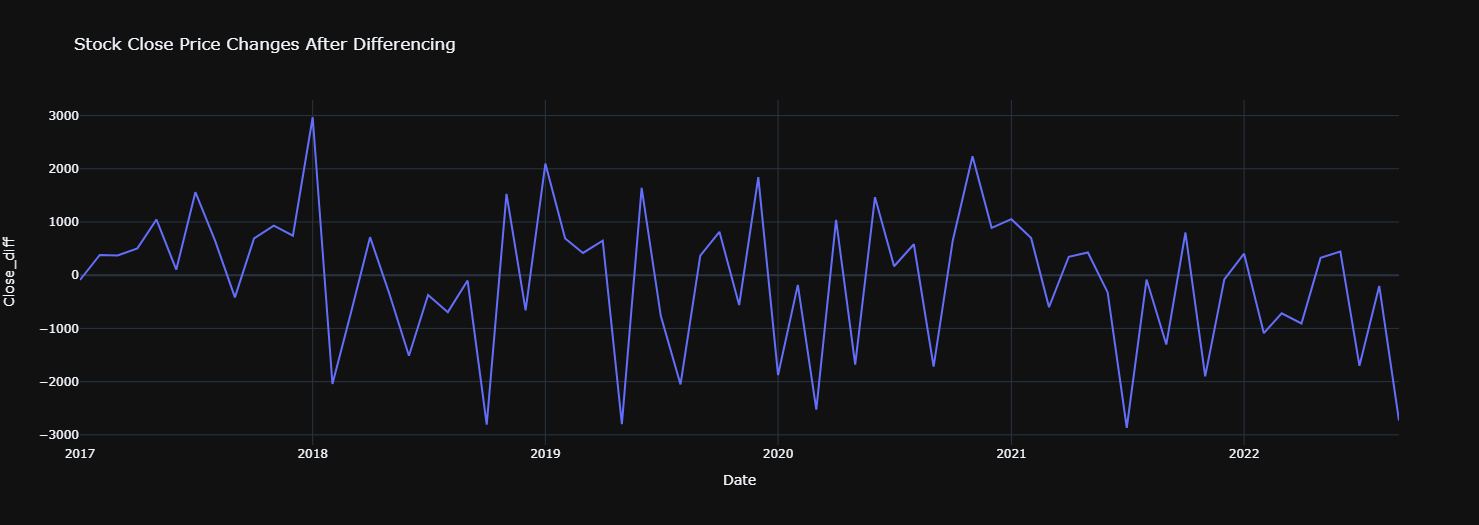

# Implementing a ARIMA (Autoregressive Integrated Moving Average) Model
-  to better understand the data or to predict future points in the series.


## Select the optimal order using AIC

In [ ]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = ARIMA(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog= df['Close_diff'])
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(1, 1, 1)",1173.487398
1,"(2, 1, 1)",1173.782953
2,"(1, 1, 2)",1174.070595
3,"(0, 1, 3)",1174.126408
4,"(0, 1, 2)",1174.267185
5,"(0, 1, 1)",1174.458121
6,"(2, 1, 2)",1175.781483
7,"(3, 1, 1)",1175.781844
8,"(0, 1, 4)",1175.993243
9,"(3, 1, 2)",1177.455039


## Model Training

In [ ]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

In [ ]:
model = ARIMA(differenced_df['Close_diff'], order=(1, 1, 1))
arma_fit = model.fit()
squared_errors = arma_fit.resid ** 2
predictions, threshold = find_anomalies(squared_errors)

In [ ]:
#0 = normal observations ; 1 = anomalous observations
df['Anomaly'] = predictions
print(df)

                   Close   Close_diff  Anomaly
Date                                          
2017-01-01  23360.779297   -90.263959      NaN
2017-02-01  23740.730469   379.951172      0.0
2017-03-01  24111.589844   370.859375      0.0
2017-04-01  24615.130859   503.541015      0.0
2017-05-01  25660.650391  1045.519532      0.0
...                  ...          ...      ...
2022-05-01  21415.199219   325.808594      0.0
2022-06-01  21859.789063   444.589844      0.0
2022-07-01  20156.509766 -1703.279297      0.0
2022-08-01  19954.390625  -202.119141      0.0
2022-09-01  17222.830078 -2731.560547      1.0

[69 rows x 3 columns]


## Result Illustration

In [ ]:
#Dont run first
import plotly.graph_objects as go
# create list of outlier_dates


# plot value on y-axis and date on x-axis
fig = px.line(df, df.index, y="Close", title='Monthly Prices of Hang Seng Index - UNSUPERVISED ANOMALY DETECTION (ARIMA Model)',   template = 'plotly_dark')
fig.update_traces(line_color='#22577A')

outlier_dates = df[df['Anomaly'] == 1].index


# obtain y value of anomalies to plot
y_values = [df.loc[i]['Close'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values,   mode = 'markers',
                text=outlier_dates.astype(str).to_list(),
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))

for i in range(len(outlier_dates)):
  fig.add_annotation(x = outlier_dates[i], y = y_values[i] ,
            text= outlier_dates.astype(str).to_list()[i][:7],
            showarrow=False,
            yshift=20)    

fig.show()

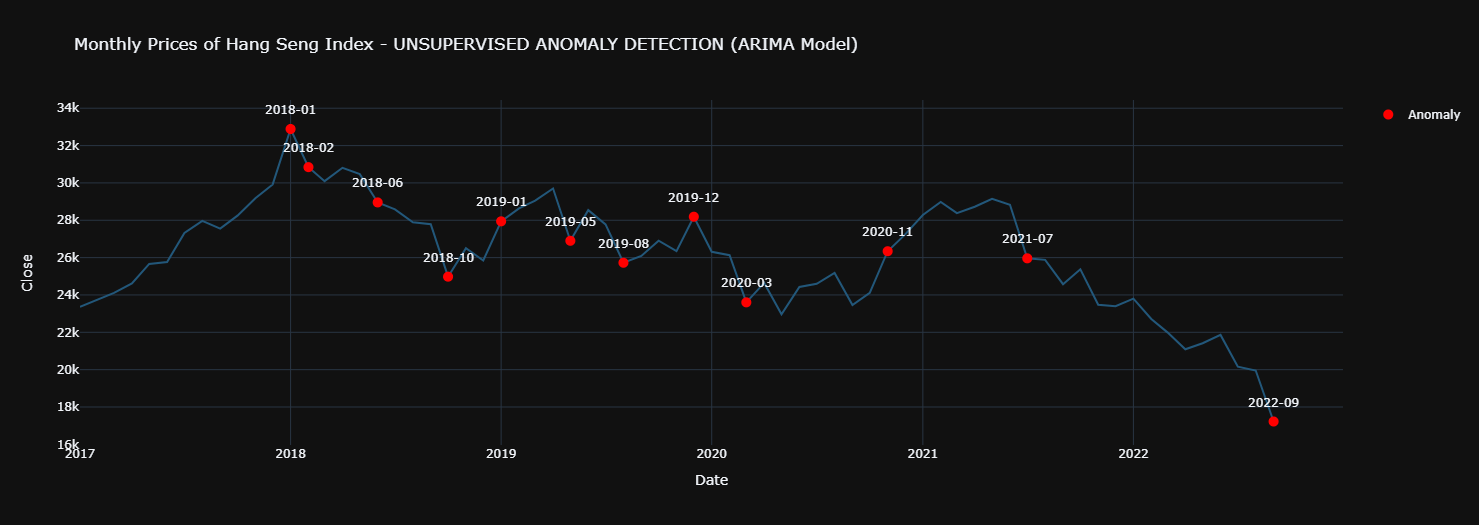

In [ ]:
outlier_dates.astype(str).to_list()

['2018-01-01',
 '2018-02-01',
 '2018-06-01',
 '2018-10-01',
 '2019-01-01',
 '2019-05-01',
 '2019-08-01',
 '2019-12-01',
 '2020-03-01',
 '2020-11-01',
 '2021-07-01',
 '2022-09-01']

In [ ]:
y_values

[32887.269531,
 24979.689453,
 28633.179688,
 28542.619141,
 26906.720703,
 26312.630859,
 23603.480469,
 25177.050781,
 26341.490234,
 28283.710938,
 25961.029297,
 23475.259766]